## import module 

In [1]:
import cv2
from skimage import color 
import numpy as np
import math
import matplotlib.pyplot as plt

## histogram class

In [2]:
path = './drive/MyDrive';
target= './drive/MyDrive/target'
class HistogramHolder:
    def setHist(self,H):
        self.H=H
    def getHist(self):
        return self.H
    def setdiff(self,D):
        self.D=D
    def getdiff(self):
        return self.D
    def setv(self,v):
        self.v=v
    def getv(self):
        return self.v
    def setpmin(self,pmin):
        self.pmin=pmin
    def getpmin(self):
        return self.pmin
    def setpmax(self,pmax):
        self.pmax=pmax
    def getpmax(self):
        return  self.pmax

## some function

In [3]:
BINS = 400
def find_peaks(H): #for the min and max partial region
    pmax=[]
    pmin=[]
    for i in range(len(H)):
        if (H[i]>=0):
            H[i]=1
        else:
            H[i]=-1

    H2 = np.diff(H,axis=-1)
    np.insert(H2,len(H2),0)
    for i in range(len(H2)):
        if (H2[i]<0):
            pmax.append(i)
        elif (H2[i]>0):
            pmin.append(i)

    return [pmax,pmin]

def hdrhist(I,BINS,minV,maxV):
    w,h=I.shape
    L=np.reshape(I.T,(1,w*h))
    #print(L.shape)
    step = (maxV-minV) * (1.0/(BINS-1))
    if step <= 0:
        step = 1

    v=np.arange(minV, maxV+step, step)
    H,V=np.histogram(L,v)
    return H,v

def hdrhistc(I,BINS):
    w,h=I.shape
    L=np.reshape(I.T,(1,w*h))
    minV=L.min()
    maxV=L.max()
    step = (maxV-minV) * (1.0/(BINS-1))
    if step <= 0:
        step = 1
    v=np.arange(minV, maxV+step, step)
    H,V=np.histogram(L[0],len(v))
    Hc=np.cumsum(H)
    return Hc,v

#for Hist_matching
def Hist_match(Iin,Ho,vs):
    Iout = np.ones(Iin.shape) * -1.0
    Iin=np.float32(Iin)

    Ht = np.double(Ho.cumsum())
    out = np.zeros(Ho.shape, np.double)
    normalized = cv2.normalize(Ht, out, 1.0, 0.0, cv2.NORM_MINMAX)

    Ht=normalized

    vt=np.float32(vs)

    BINS=len(Ht)
    Hin,vin=hdrhistc(Iin,BINS)

    Hin = np.double(Hin)
    out = np.zeros(Hin.shape, np.double)
    normalized = cv2.normalize(Hin, out, 1.0, 0.0, cv2.NORM_MINMAX)
    Hin = normalized
    step=vin[1]-vin[0]
    tempcin=Iin
    tempcout=Iout
    count=1
    for i in range(BINS):
        x=np.nonzero(Hin[:]<=Ht[i])
        subvin = vin[x]
        if len(subvin)>=1:
            if count==1:

                valst=np.min(np.min(tempcin))
                valend=subvin[len(subvin)-1]
                idx=np.nonzero(tempcin[:,:]>=valst)
                #print(tempcin[:,:])

            else:
                valst=valend
                valend=subvin[len(subvin)-1]
                idx=np.nonzero(tempcin>valst)

            idx2=np.nonzero(tempcin[idx] <= valend)
            temp=tempcout[idx]
            temp[idx2]=vt[i]
            #print(temp[idx2])
            tempcout[idx] = temp
            #print(tempcout[idx])
            count = count + 1

            if (count > BINS) and len(np.nonzero(vt<0)[0])==0:

                index=np.nonzero(tempcout < 0)
                tempcout[index]=np.max(np.max(tempcout))

    return tempcout

def Histogram_Transfer(Hs,Ht,weight):
    #hbins=len(Hs)
    #if hbins!=len(Ht):
        #print('Mayday we have a problem Incorrect histogram length')
    wt=weight
    ws=1-wt
    mt= np.mean(Ht)*wt+np.mean(Hs)*ws
    ms= np.mean(Hs)
    st=np.std(Ht)*wt + np.std(Hs)*ws
    ss = np.std(Hs)
    Hm = Hs - ms
    if ss!=0:
        Hm = Hm * (st / ss)
    Ho = Hm + mt
    return Ho

def Hist_multi_scales(Hs,Ht,Vs,Vt,Bins,Cs):

    Smax=math.log2(Bins/10)+1
    Smax=int(Smax)
    S=Smax

    #target and source smax for histogram
    St=[HistogramHolder() for j in range(S)]
    Ss=[HistogramHolder() for j in range(S)]

    Ht = np.reshape(Ht, (1, len(Ht)))

    #set mutiscale for hostogram
    for i in range(S):
        a = 1/2 ** (Smax-(i+1))
        k = int(Ht.size * a)

        St[i].setHist(cv2.resize(Ht, (k,1),interpolation = cv2.INTER_CUBIC))
        St[i].setHist(cv2.resize(St[i].getHist(),(Bins,1),interpolation = cv2.INTER_CUBIC)[0])

        St[i].setv(Vt)
        Ss[i].setHist(Hs)
        Ss[i].setv(Vs)
        St[i].setdiff(np.diff(St[i].getHist()))
        St[i].setdiff(np.insert(St[i].getdiff(),0,St[i].getdiff()[0]))
        pmin,pmax= find_peaks(St[i].getdiff())
        St[i].setpmin(pmin)
        St[i].setpmax(pmax)

    Hm=[]

    for i in range(0,S):
        if i==0:
            im=i
        else:
            im=i-1

        if len(St[i].getpmin())!=0 and len(St[i].getpmax())!=0:
            peaks=len(St[i].getpmin())
            for ip in range(peaks):
                if ip==0:
                    ist=0
                    iend=St[i].getpmin()[ip]
                    k=i+1
                    Hm[ist:iend]=Histogram_Transfer(Ss[im].getHist()[ist:iend],St[i].getHist()[ist:iend],k/Smax)
                    #from paper
                else:
                    k=i+1
                    ist=St[i].getpmin()[ip-1]
                    iend=St[i].getpmin()[ip]
                    Hm[ist:iend]=Histogram_Transfer(Ss[im].getHist()[ist:iend],St[i].getHist()[ist:iend],k/Smax)
                    #from paper

            k=i+1
            ist=St[i].getpmin()[len(St[i].getpmin())-1]
            iend=len(St[i].getHist())

            Hm[ist:iend] = Histogram_Transfer(Ss[im].getHist()[ist:iend], St[i].getHist()[ist:iend], k / Smax)
        else:
            Hm = Histogram_Transfer(Ss[im].getHist(), St[i].getHist(), S / Smax)
        #print(Hm)
        for j in range(len(Hm)):
            if (Hm[j] < 0):
                Hm[j] = 0

        Hmnpa = np.asarray(Hm, dtype=np.float32)

        Ss[i].setHist(Hmnpa)

        Hm = []
        Hmnpa = []

        a = 1 / 2 ** (Smax - (i + 1))
        k = int(len(Ss[i].getHist()) * a)

        tempHs = cv2.resize(Ss[i].getHist(), (k, 1),interpolation = cv2.INTER_CUBIC)
        tempHs = cv2.resize(tempHs, (Bins,1),interpolation = cv2.INTER_CUBIC)[0]

        Ss[i].setdiff(np.diff(tempHs, axis=0))

        Ss[i].setdiff(np.insert(Ss[i].getdiff(), 0, Ss[i].getdiff()[0]))

        pmin, pmax = find_peaks(Ss[i].getdiff())

        Ss[i].setpmin(pmin)
        Ss[i].setpmax(pmax)

        if len(Ss[i].getpmin()) != 0 and len(Ss[i].getpmax()) != 0:
            peaks = len(Ss[i].getpmin())
            for ip in range(peaks):
                if ip == 0:
                    ist = 0
                    iend = Ss[i].getpmin()[ip]
                    k = i + 1
                    Hm[ist:iend] = Histogram_Transfer(Ss[i].getHist()[ist:iend], St[i].getHist()[ist:iend], k / Smax)

                else:
                    k = i + 1
                    ist = Ss[i].getpmin()[ip - 1]
                    iend = Ss[i].getpmin()[ip]
                    Hm[ist:iend] = Histogram_Transfer(Ss[i].getHist()[ist:iend], St[i].getHist()[ist:iend], k / Smax)

            k = i + 1
            ist = Ss[i].getpmin()[len(Ss[i].getpmin()) - 1]
            iend = len(Ss[i].getHist())

            Hm[ist:iend] = Histogram_Transfer(Ss[i].getHist()[ist:iend], St[i].getHist()[ist:iend], k / Smax)


        else:

            Hm = Histogram_Transfer(Ss[i].getHist(), St[i].getHist(), S / Smax)

        #print(Hm)
        plt.plot(Hm)
        plt.title("source hist(modified) "+str(i))
        plt.show()
        for j in range(len(Hm)):
            if (Hm[j] < 0):
                Hm[j] = 0
        Hmnpa = np.asarray(Hm, dtype=np.float32)
        Ss[i].setHist(Hmnpa)
        Hm = []
        Hmnpa = []
    if S > 0:
        Ho = Ss[i].getHist() / np.sum(Ss[i].getHist())
        Ho = Ho * len(Cs)

        for i in range(len(Ho)):
            if (Ho[i] > 0):
                vmin = i
                break

        for i in range(len(Ho) - 1, 0, -1):
            if (Ho[i] > 0):
                vmax = i
                break

        Cs = np.double(Cs)
        out = np.zeros(Cs.shape, np.double)
        normalized = cv2.normalize(Cs, out, 1.0, 0.0, cv2.NORM_MINMAX)
        Co=Hist_match(normalized,Ho[vmin:vmax],Vs[vmin:vmax])
        Co = np.double(Co)
        out = np.zeros(Co.shape, np.double)
        normalized = cv2.normalize(Co, out, 1.0, 0.0, cv2.NORM_MINMAX)
        Co=normalized*(Vs[vmax]-Vs[vmin])+Vs[vmin]

    return Co


def changeColor(source,channel,dataPath,des_images):
    ref = 65
    src_image_lab=color.rgb2lab(source)
    Is=src_image_lab[:,:,channel]
    Is=np.float32(Is)
    minV = 1000
    maxV = 0

    Ct=[]
    Ct.append(0)

    target_image = target
    target_image_lab = color.rgb2lab(target_image)
    It=target_image_lab[:,:,channel]
    Ct[0]= np.float32(It)

    minV=np.min([np.min(np.min(Ct[0])),minV])
    maxV=np.max([np.max(np.max(Ct[0])),maxV])

    minV=np.min([np.min(np.min(Is)),minV])
    maxV=np.max([np.max(np.max(Is)),maxV])
    Hs,vs=hdrhist(Is,BINS,minV,maxV) #source image histogram
    Hs=Hs/len(Is)
    plt.plot(Hs)
    plt.title("source hist")
    plt.show()

    Ht=[]
    vt=[]

    H,v= hdrhist(Ct[0],BINS+1,minV,maxV)
    H=H/len(Ct[0])
    plt.plot(H)
    plt.title("target hist")
    plt.show()

    Ht.append(H)
    vt.append(v)

    Htar = np.zeros(len(Ht[0]))
    vtar = np.zeros(len(vt[0]))

    tempHist=[]
    tempVal=[]

    #print(len(Ht))
    tempHist.append(Ht[0]*1.0)
    b = np.array(tempHist)
    Htar=Htar+tempHist[0]
    tempVal.append(vt[0]*1.0)
    vtar=vtar+tempVal[0]


    #print("Len of Htar: "+str(len(Htar)))

    return Hist_multi_scales(Hs,Htar,vs,vtar,BINS,Is),src_image_lab



## main function => color tranfer

In [4]:
def GetTransformedImage(source,des_images,filename):
    
    IoM_channel_a,src_image_lab=changeColor(source,1,path,des_images)

    #if len(IoM_channel_a)!= 400:
    #    global BINS
    #    BINS = len(IoM_channel_a)
    #    print("BINS MOFO "+str(BINS))

    IoM_channel_b, b = changeColor(source,2,path,des_images)
    target_rgb=cv2.merge((src_image_lab[:,:,0], IoM_channel_a, IoM_channel_b))
    trans=color.lab2rgb(target_rgb)
    cv2.imwrite(filename, trans*255)

## Run code

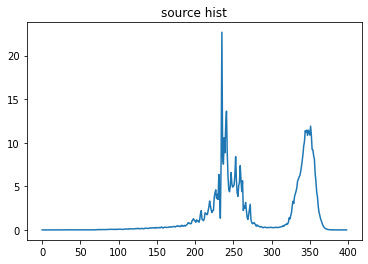

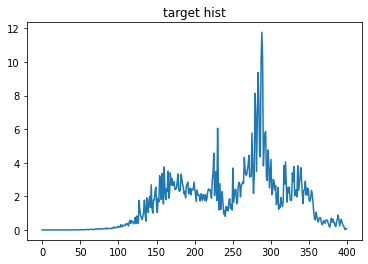

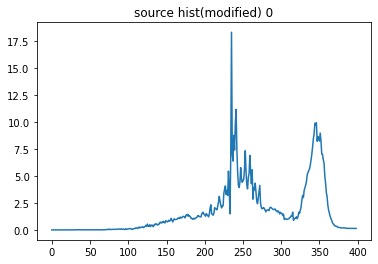

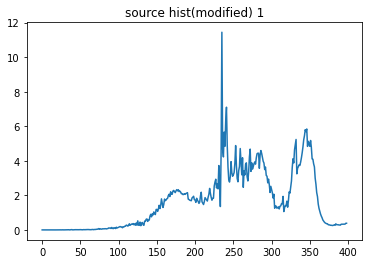

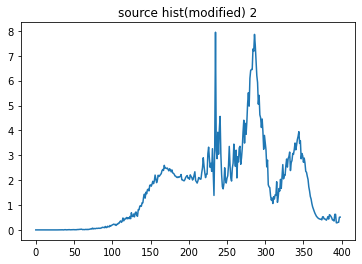

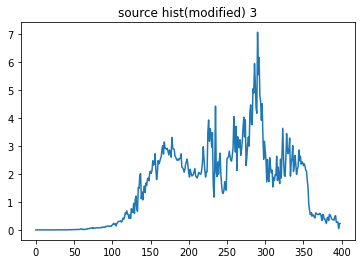

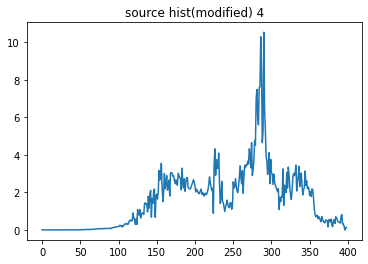

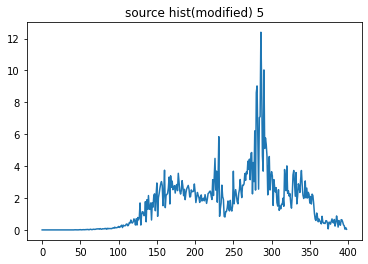

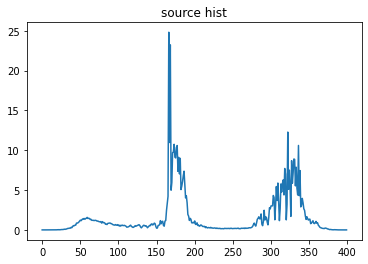

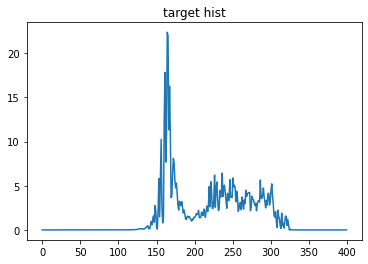

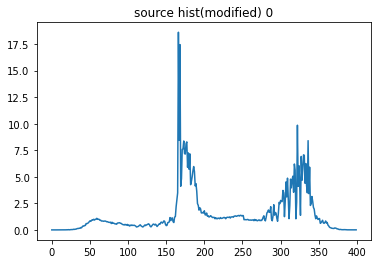

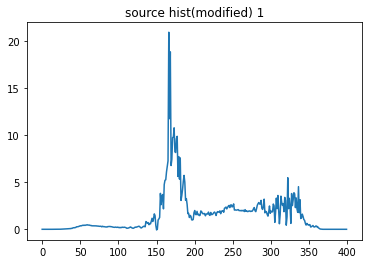

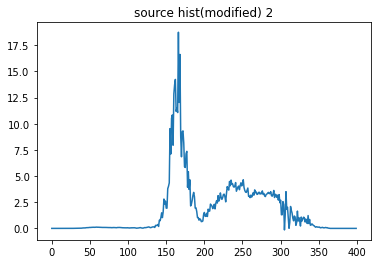

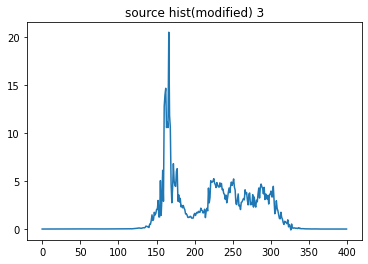

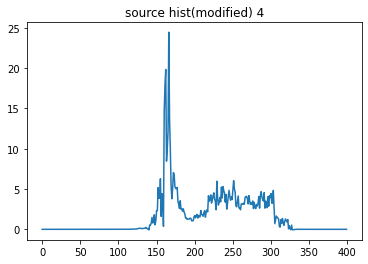

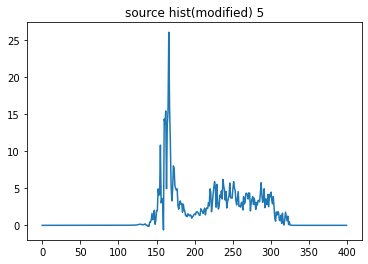

In [8]:
source=cv2.imread("./drive/MyDrive/s5.jpg")
target=cv2.imread("./drive/MyDrive/s3.jpg")
result="result.jpg"
GetTransformedImage(source,target,result)